# Step 3.2: GitHub Log Analysis

In [1]:
import pandas as pd 
import os
import csv
import re
import json
from collections import Counter
from os import listdir
results_dir = "/home/notebooks/ProjectAnalysis/GitHubProyectsAnalysis/results/"
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format

In [2]:
def getSummary(project_name, commit_history):
    summary = {}
    summary['Project'] = project_name
    summary["Total"] = 0
    summary["Success"] = 0
    summary["Fail"] = 0
    
    summary['MavenSuccess'] = 0
    summary['MavenFail'] = 0
    summary['GradleSuccess'] = 0
    summary['GradleFail'] = 0
    summary['AntSuccess'] = 0
    summary['AntFail'] = 0
    summary['NoBuildSystem'] = 0
    summary['Errors'] = []
    
    
    for result in commit_history:
        
        summary["Total"] += 1
        
        if result['BUILD_STATUS'] == 'SUCCESS':
            
            summary["Success"] += 1
        
            if result['BUILD_SYSTEM'] == 'Maven':
                summary['MavenSuccess'] += 1
            if result['BUILD_SYSTEM'] == 'Gradle':
                summary['GradleSuccess'] += 1
            if result['BUILD_SYSTEM'] == 'Ant':
                summary['AntSuccess'] += 1
                
        else: # FAILED BUILDS
            
            if result['ERROR'] == 'No build system detected':
                summary['NoBuildSystem'] += 1
            
            summary["Fail"] += 1
            
            if result['BUILD_SYSTEM'] == 'Maven':
                summary['MavenFail'] += 1
            if result['BUILD_SYSTEM'] == 'Gradle':
                summary['GradleFail'] += 1
            if result['BUILD_SYSTEM'] == 'Ant':
                summary['AntFail'] += 1
#             if result['BUILD_SYSTEM'] == 'NOT_FOUND':
#                 summary['NoBuildSystem'] += 1
            
            action = result['ACTION']
            if action not in ['Resolution', 'Parsing', 'Compilation', 'Other']:
                if result['ERROR'] == 'Timeout': 
                    action = 'Resolution'
                else:
                    action = 'Other'
                
            summary['Errors'].append((result['BUILD_SYSTEM'], result['ERROR'], action))
                
    return summary

In [3]:
projects = [f for f in listdir(results_dir)]
results = {}

all_projects_summary = []
early_snapshots = []
intermediate_snapshots = []
recent_snapshots = []

for result_file in projects:
    with open(results_dir+result_file) as csvfile:
        project_name = result_file.split(".")[0]
        commit_history = list(csv.DictReader(csvfile))
        #results[project_name]= commit_history
        
        size = len(commit_history)
        q1 = int(0.25*size)
        q3 = int(0.75*size)
        
        all_projects_summary.append(getSummary(project_name, commit_history))

        early_snapshots.append(getSummary(project_name, commit_history[:q1]))

        intermediate_snapshots.append(getSummary(project_name, commit_history[q1+1:q3]))
        
        recent_snapshots.append(getSummary(project_name, commit_history[q3+1:]))


In [4]:
headers = ['Project', 'Total', 'Success', 'Fail', 'MavenSuccess', 'MavenFail', 'GradleSuccess', 'GradleFail', 'AntSuccess', 'AntFail', 'NoBuildSystem']

In [5]:
def piePlotPerBuildSystem(df):

    fig = plt.figure(figsize=(9,9))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    summary_build_systems = df.select_dtypes(pd.np.number).sum()
    # Maven
    summary_build_systems[['MavenFail', 'MavenSuccess']].plot.pie(title="Maven",autopct = "%.2f%%", ax=ax1, colors = ['red', 'green'])
    # Gradle
    summary_build_systems[['GradleFail', 'GradleSuccess']].plot.pie(title="Gradle", autopct = "%.2f%%", ax=ax2, colors = ['red', 'green'])
    # Ant
    summary_build_systems[['AntFail', 'AntSuccess']].plot.pie(title="Ant", autopct = "%.2f%%", ax=ax3, colors = ['red', 'green'])

## 1. Projects Summary - All snapshots

In [6]:
summary_df = pd.DataFrame(all_projects_summary)
summary_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,webmagic,1132,999,133,999,133,0,0,0,0,0
1,netty,10000,1379,8621,1379,8621,0,0,0,0,0
2,logback,4088,2834,1254,2834,1248,0,0,0,0,6
3,resteasy,4837,310,4527,310,4043,0,0,0,0,484
4,spring-cloud-config,1588,842,746,842,746,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
75,java-client,1614,424,1190,424,315,0,831,0,0,44
76,java-driver,1723,783,940,783,940,0,0,0,0,0
77,soot,6785,960,5825,960,1257,0,0,0,3500,1068
78,assertj-core,3486,2901,585,2901,585,0,0,0,0,0


Generate resume for Reproduction Experiment

In [7]:
summary_df[headers].to_csv('reproduction_experiment_buildability_summary.csv', index=False)  

In [8]:
summary_df.select_dtypes(pd.np.number).sum()

<ipython-input-8-52cd6aaad616>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  summary_df.select_dtypes(pd.np.number).sum()


Total            300279
Success           98488
Fail             201791
MavenSuccess      80310
MavenFail        110753
GradleSuccess     13737
GradleFail        50358
AntSuccess         4441
AntFail           21294
NoBuildSystem     19386
dtype: int64

In [9]:
summary_per_build_system = pd.DataFrame(columns=['#Commits','#Build success','Fraction built'], index=['Maven','Gradle','Ant'])
# SEGUIR
for bs in ['Maven', 'Gradle', 'Ant']:
    success = summary_df[bs+'Success'].sum()
    total = success + summary_df[bs+'Fail'].sum()
    fraction = (success / total)*100
    summary_per_build_system.loc[bs] = pd.Series(
        {'#Commits': total, '#Build success': success, 'Fraction built': fraction }
    )
total = summary_per_build_system['#Commits'].sum()
success = summary_per_build_system['#Build success'].sum()
fraction = (success / total)*100
summary_per_build_system.loc['All'] = pd.Series(
        {'#Commits': total, '#Build success': success, 'Fraction built': fraction }
    )
summary_per_build_system

,#Commits,#Build success,Fraction built
Maven,"191,063.0","80,310.0",42.03
Gradle,"64,095.0","13,737.0",21.43
Ant,"25,735.0","4,441.0",17.26
All,"280,893.0","98,488.0",35.06


In [10]:
commitsWithNoBuildSystem = summary_df.select_dtypes(pd.np.number).sum()['NoBuildSystem']

<ipython-input-10-43548d657465>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  commitsWithNoBuildSystem = summary_df.select_dtypes(pd.np.number).sum()['NoBuildSystem']


In [11]:
def report(data):
    error_list = []
    total_errors = len(data) - commitsWithNoBuildSystem
    for error_tuple in Counter(data).items():
        build_system, error, action = error_tuple[0]
        if build_system == "NOT_FOUND": continue
        count = error_tuple[1]
        error_list.append((build_system, error, action, count))
    errors = sorted(error_list, key=lambda i: i[3], reverse=True)
    errors = pd.DataFrame(errors, columns = ["BuildSystem", "Error", "Action", "Count"])
    errors['%'] = errors.apply (lambda row: (row[3] / total_errors)*100, axis=1)
    print(errors[['Count', '%']].sum())
    return errors 

In [12]:
all_errors_df = report(summary_df["Errors"].sum())
all_errors_df.head(40)

Count   182,405.00
%           100.00
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,74950,41.09
1,Maven,MojoFailureException,Other,12426,6.81
2,Maven,MojoExecutionException,Other,11562,6.34
3,Ant,"Target ""compile"" does not exist in the project",Other,8615,4.72
4,Gradle,IOException: Server returned HTTP response code,Resolution,8057,4.42
5,Gradle,Could not resolve,Resolution,7057,3.87
6,Gradle,Could not resolve all dependencies,Resolution,6899,3.78
7,Maven,ConnectException,Other,5524,3.03
8,Gradle,Task 'test' not found in root project,Other,5215,2.86
9,Gradle,Execution failed for task,Other,4726,2.59


In [13]:
all_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Resolution,102551,56.22
Other,74437,40.81
Compilation,3450,1.89
Parsing,1967,1.08


<AxesSubplot:title={'center':'Maven'}, ylabel='Count'>

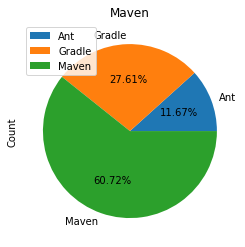

In [14]:
all_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

<ipython-input-5-9f9daa7cd71b>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  summary_build_systems = df.select_dtypes(pd.np.number).sum()


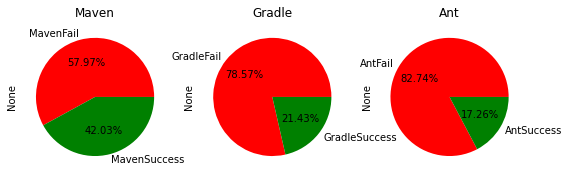

In [15]:
piePlotPerBuildSystem(summary_df)

## 2. Projects Summary - Early Snapshots

In [16]:
early_snapshots_df = pd.DataFrame(early_snapshots)
early_snapshots_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,webmagic,283,268,15,268,15,0,0,0,0,0
1,netty,2500,598,1902,598,1902,0,0,0,0,0
2,logback,1022,506,516,506,510,0,0,0,0,6
3,resteasy,1209,1,1208,1,724,0,0,0,0,484
4,spring-cloud-config,397,0,397,0,397,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
75,java-client,403,339,64,339,20,0,0,0,0,44
76,java-driver,430,223,207,223,207,0,0,0,0,0
77,soot,1696,0,1696,0,0,0,0,0,756,940
78,assertj-core,871,617,254,617,254,0,0,0,0,0


In [17]:
early_snapshots_df.select_dtypes(pd.np.number).sum()

<ipython-input-17-69adcb90b9b4>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  early_snapshots_df.select_dtypes(pd.np.number).sum()


Total            75041
Success          19315
Fail             55726
MavenSuccess     15471
MavenFail        29058
GradleSuccess      467
GradleFail        5058
AntSuccess        3377
AntFail           9979
NoBuildSystem    11631
dtype: int64

In [18]:
early_errors_df = report(early_snapshots_df["Errors"].sum())
early_errors_df

Count   44,095.00
%          121.34
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,18690,51.43
1,Ant,"Target ""compile"" does not exist in the project",Other,4379,12.05
2,Maven,MojoFailureException,Other,3596,9.90
3,Maven,ConnectException,Other,3253,8.95
4,Gradle,IOException: Server returned HTTP response code,Resolution,2821,7.76
...,...,...,...,...,...
60,Ant,b'Apache Ant(TM) version 1.10.11 compiled on J...,Other,2,0.01
61,Ant,b'Apache Ant(TM) version 1.10.11 compiled on J...,Other,1,0.00
62,Ant,Source resource does not exist,Other,1,0.00
63,Ant,b'Apache Ant(TM) version 1.10.11 compiled on J...,Other,1,0.00


In [19]:
early_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Resolution,23606,64.96
Other,18945,52.13
Compilation,1303,3.59
Parsing,241,0.66


<AxesSubplot:title={'center':'Maven'}, ylabel='Count'>

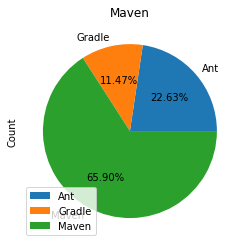

In [20]:
early_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

<ipython-input-5-9f9daa7cd71b>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  summary_build_systems = df.select_dtypes(pd.np.number).sum()


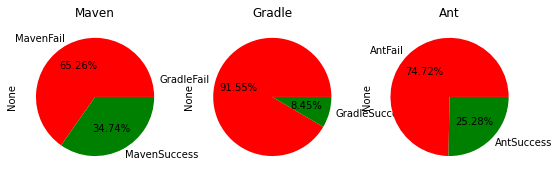

In [21]:
piePlotPerBuildSystem(early_snapshots_df)

## 3. Projects Summary - Intemediate Snapshots

In [22]:
intermediate_snapshots_df = pd.DataFrame(intermediate_snapshots)
intermediate_snapshots_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,webmagic,565,470,95,470,95,0,0,0,0,0
1,netty,4999,780,4219,780,4219,0,0,0,0,0
2,logback,2043,1650,393,1650,393,0,0,0,0,0
3,resteasy,2417,0,2417,0,2417,0,0,0,0,0
4,spring-cloud-config,793,518,275,518,275,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
75,java-client,806,84,722,84,295,0,427,0,0,0
76,java-driver,861,542,319,542,319,0,0,0,0,0
77,soot,3391,73,3318,73,447,0,0,0,2743,128
78,assertj-core,1742,1581,161,1581,161,0,0,0,0,0


In [23]:
intermediate_snapshots_df.select_dtypes(pd.np.number).sum()

<ipython-input-23-5b7744bc43e5>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  intermediate_snapshots_df.select_dtypes(pd.np.number).sum()


Total            150058
Success           48216
Fail             101842
MavenSuccess      39674
MavenFail         56468
GradleSuccess      7635
GradleFail        28934
AntSuccess          907
AntFail            9533
NoBuildSystem      6907
dtype: int64

In [24]:
intermediate_errors_df = report(intermediate_snapshots_df["Errors"].sum())
intermediate_errors_df

Count   94,935.00
%          115.13
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,42453,51.49
1,Maven,MojoExecutionException,Other,5157,6.25
2,Maven,MojoFailureException,Other,5128,6.22
3,Gradle,IOException: Server returned HTTP response code,Resolution,5024,6.09
4,Gradle,Could not resolve all dependencies,Resolution,4736,5.74
5,Ant,"Target ""compile"" does not exist in the project",Other,4032,4.89
6,Gradle,Cannot run program,Other,3849,4.67
7,Gradle,Task 'test' not found in root project,Other,3016,3.66
8,Ant,Unable to find property file,Other,2740,3.32
9,Gradle,Other Gradle error,Other,2559,3.10


In [25]:
intermediate_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Resolution,57164,69.33
Other,35987,43.64
Compilation,1281,1.55
Parsing,503,0.61


<AxesSubplot:title={'center':'Maven'}, ylabel='Count'>

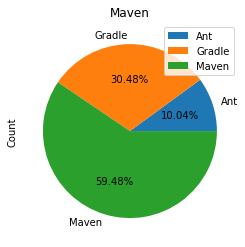

In [26]:
intermediate_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

<ipython-input-5-9f9daa7cd71b>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  summary_build_systems = df.select_dtypes(pd.np.number).sum()


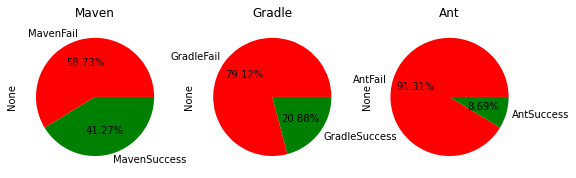

In [27]:
piePlotPerBuildSystem(intermediate_snapshots_df)

## 4. Projects Summary - Recent Snapshots

In [28]:
recent_snapshots_df = pd.DataFrame(recent_snapshots)
recent_snapshots_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,webmagic,282,260,22,260,22,0,0,0,0,0
1,netty,2499,0,2499,0,2499,0,0,0,0,0
2,logback,1021,677,344,677,344,0,0,0,0,0
3,resteasy,1209,309,900,309,900,0,0,0,0,0
4,spring-cloud-config,396,323,73,323,73,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
75,java-client,403,0,403,0,0,0,403,0,0,0
76,java-driver,430,17,413,17,413,0,0,0,0,0
77,soot,1696,886,810,886,810,0,0,0,0,0
78,assertj-core,871,702,169,702,169,0,0,0,0,0


In [29]:
recent_snapshots_df.select_dtypes(pd.np.number).sum()

<ipython-input-29-946a0b52704f>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  recent_snapshots_df.select_dtypes(pd.np.number).sum()


Total            75020
Success          30893
Fail             44127
MavenSuccess     25113
MavenFail        25174
GradleSuccess     5626
GradleFail       16342
AntSuccess         154
AntFail           1772
NoBuildSystem      839
dtype: int64

In [30]:
recent_errors_df = report(recent_snapshots_df["Errors"].sum())
recent_errors_df

Count   43,288.00
%          174.96
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,13770,55.66
1,Gradle,Could not resolve,Resolution,4936,19.95
2,Maven,MojoExecutionException,Other,4401,17.79
3,Maven,MojoFailureException,Other,3698,14.95
4,Gradle,Execution failed for task,Other,2727,11.02
5,Gradle,Task 'test' not found in root project,Other,2198,8.88
6,Ant,UnknownHostException,Resolution,1449,5.86
7,Maven,ConnectException,Other,1315,5.32
8,Gradle,Other Gradle error,Other,1275,5.15
9,Maven,PluginDescriptorParsingException,Parsing,1208,4.88


In [31]:
recent_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Resolution,21729,87.83
Other,19472,78.70
Parsing,1222,4.94
Compilation,865,3.50


<AxesSubplot:title={'center':'Maven'}, ylabel='Count'>

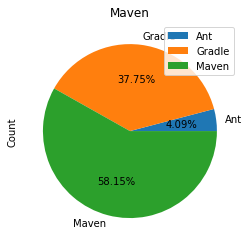

In [32]:
recent_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

<ipython-input-5-9f9daa7cd71b>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  summary_build_systems = df.select_dtypes(pd.np.number).sum()


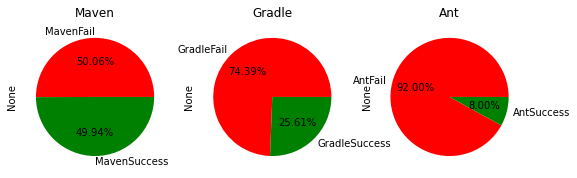

In [33]:
piePlotPerBuildSystem(recent_snapshots_df)

## 5. Errors per Build System

In [34]:
maven_errors  = []
ant_errors    = []
gradle_errors = []

maven_errors_complete  = []
ant_errors_complete    = []
gradle_errors_complete = []

for project in all_projects_summary:
    for error in project['Errors']:
        build_system = error[0]
        trace        = error[1]
        category     = error[2]
        if build_system == 'Maven':
            maven_errors.append(category)
            maven_errors_complete.append((trace, category))
        if build_system == 'Ant':
            ant_errors.append(category)
            ant_errors_complete.append((trace, category))
        if build_system == 'Gradle':
            gradle_errors.append(category)
            gradle_errors_complete.append((trace, category))

In [35]:
from collections import Counter

all_errors = maven_errors + ant_errors + gradle_errors

errors_per_bs = []

for build_system, errors in [("Maven",maven_errors), ("Ant",ant_errors), ("Gradle",gradle_errors), ("All", all_errors)]:
    counter = Counter(errors)
    errors_per_bs.append([
        build_system, 
        int(counter['Resolution']),
        int(counter['Resolution'])*100/len(errors),
        int(counter['Parsing']),
        int(counter['Parsing'])*100/len(errors),
        int(counter['Compilation']),
        int(counter['Compilation'])*100/len(errors),
        int(counter['Other']),
        int(counter['Other'])*100/len(errors)
    ])
errors_per_bs_df = pd.DataFrame(errors_per_bs, columns = [
    'Build System', 
    'Resolution Err. (#)',
    'Resolution Err. (%)',
    'Parsing Err. (#)',
    'Parsing Err. (%)',
    'Compilation Err. (#)',
    'Compilation Err. (%)',
    'Other Err. (#)',
    'Other Err. (%)'
])

errors_per_bs_df 

,Build System,Resolution Err. (#),Resolution Err. (%),Parsing Err. (#),Parsing Err. (%),Compilation Err. (#),Compilation Err. (%),Other Err. (#),Other Err. (%)
0,Maven,75806,68.45,1967,1.78,0,0.00,32980,29.78
1,Ant,4485,21.06,0,0.00,1077,5.06,15732,73.88
2,Gradle,22260,44.20,0,0.00,2373,4.71,25725,51.08
3,All,102551,56.22,1967,1.08,3450,1.89,74437,40.81
